In [1]:
# default_exp core
# default_cls_lvl 3

In [14]:
# export

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
# import Displacement.library.trak_utils as tu
import PIL
import numpy as np
import pandas

In [7]:
#hide
from nbdev.showdoc import *

# Show a numpy image

In [41]:
# export
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

# Take a small rectangular slice of a large image

In [25]:
# export
def sliceImage(img, size, pos):
    sz0 = size[0] // 2
    sz1 = size[1] // 2

    pos[0] = min(pos[0], img.shape[0] - sz0)
    pos[0] = max(pos[0], 0 + sz0)
    pos[1] = min(pos[1], img.shape[1] - sz1)
    pos[1] = max(pos[1], 0 + sz1)

    b0 = pos[0] - sz0
    e0 = pos[0] + sz0
    b1 = pos[1] - sz1
    e1 = pos[1] + sz1

    # sl = img[b0:e0, b1:e1, :]
    sl = img[b0:e0, b1:e1]
    return sl, pos

# Make a random natural look walk trajectory

In [ ]:
# export
def make_trajectory1(length, width, scale=1):
    xy = (np.random.rand(length, width) - 0.5) * scale
    return np.cumsum(xy, axis=0)


def make_trajectory2(length, scale=1):
    theta = 2 * np.pi * (np.random.rand(length) - 0.5) * 0.4
    theta = np.cumsum(theta, axis=0)
    xy = np.column_stack((np.cos(theta), np.sin(theta)))
    return np.cumsum(xy, axis=0) * scale

START_POS = np.array((0,0))

def make_trajectory3(length, xyscale=1, zscale=0.1, zcycles=3, acycles=3, deg=5, startpos=[1000,1000]):
    global START_POS
    START_POS = np.array(startpos)
    theta = 2 * np.pi * (np.random.rand(length) - 0.5) * 0.4
    theta = np.cumsum(theta, axis=0)
    z = np.sin(np.linspace(0, zcycles * 2 * np.pi, num=length)) * zscale + 1
    angles = (np.sin(np.linspace(0, acycles * 2 * np.pi, num=length)) * 0.5 + 0.5) * deg
    xy = np.column_stack((np.cos(theta), np.sin(theta)))
    xy[0,0], xy[0,1] = 0, 0  # start at zero
    xy = ((np.cumsum(xy, axis=0)) * xyscale)
    xyza = np.column_stack((xy, z, angles))
    return xyza

# Get next item in a trajectory

In [2]:
# export
def get_next(trajectory, i: int):
    dy = int(trajectory[i, 0] + START_POS[0])
    dx = int(trajectory[i, 1] + START_POS[1])
    da = trajectory[i, 3]
    return [dy, dx, 0, da]

# Rotate an image

In [27]:
# export
def rotate(image, angle, center=None, scale=1.0):
    # grab the dimensions of the image
    (h, w) = image.shape[:2]

    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        center = (w // 2, h // 2)

    # perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    # return the rotated image
    return rotated


# 

In [8]:
def track_features(img0, img1):
    img0_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    # Detect feature points in previous frame
    img0_pts = cv2.goodFeaturesToTrack(img0_gray,
                                       maxCorners=200,
                                       qualityLevel=0.2,
                                       minDistance=30,
                                       blockSize=5)

    # Convert to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow (i.e. track feature points)
    img1_pts, status, err = cv2.calcOpticalFlowPyrLK(img0_gray, img1_gray, img0_pts, None)

    # Sanity check
    assert img0_pts.shape == img1_pts.shape

    # Filter only valid points
    idx = np.where(status == 1)[0]
    img0_pts = img0_pts[idx]
    img1_pts = img1_pts[idx]

    # Find transformation matrix
    (m, inliers) = cv2.estimateAffinePartial2D(img0_pts, img1_pts)  # will only work with OpenCV-3 or less

    # Extract translation
    dx = m[0, 2]
    dy = m[1, 2]

    # Extract rotation angle
    da = np.arctan2(m[1, 0], m[0, 0])
    # print("Tracked points : " + str(len(img0_pts)))

    return [dx, dy, da], img0_pts

In [9]:
# export
IMAGE_PATCH_SIZE = [400, 600]
last_img = np.zeros((400, 600, 3))
last_pos = [0, 0]
# %%
def get_image_patch(img, pos, size=IMAGE_PATCH_SIZE, rot=0, scale=1.0):
    exp_size = 200
    # img0, cntr = sliceImage(img, size, pos)
    img0, cntr = sliceImage(img, [i+exp_size for i in size], pos[:2])
    rotated = rotate(img0, rot, scale=scale)
    img1, cntr0 = sliceImage(rotated, size, [(i+exp_size) // 2 for i in size])
    return img1, cntr

# %%
def next_image(img, trajectory, i):
    # global last_pos, last_img
    cur_pos = get_next(trajectory, i)

    # pos = get_next(trajectory, i )

    cur_img, move_actual = get_image_patch(img, cur_pos[:2], rot=cur_pos[3])
    #
    # # move_true = cntr[0] - last_pos[0], cntr[1] - last_pos[1], cur_pos[3]
    move_true = move_actual[0], move_actual[1], cur_pos[3]
    # __last_img = np.copy(last_img)
    # last_img = np.copy(cur_img)
    # last_pos = cur_pos.copy()
    return cur_img, move_true

(1000, 1000, 2.5)
(1000, 1000, 0.0)
(1001, 1000, 2.500000000000001)
(1002, 1000, 5.0)
(1002, 1001, 2.4999999999999982)


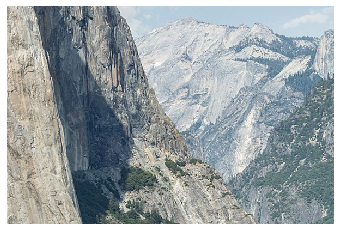

In [42]:
# export

class traj:
    def __init__(self, img, length, xyscale=1, zscale=0.1, zcycles=3, acycles=3, deg=5, startpos=[1000,1000]):
        # global START_POS
        self.img = img
        self.startpos = startpos
        # START_POS = np.array(startpos)
        theta = 2 * np.pi * (np.random.rand(length) - 0.5) * 0.4
        theta = np.cumsum(theta, axis=0)
        z = np.sin(np.linspace(0, zcycles * 2 * np.pi, num=length)) * zscale + 1
        angles = (np.sin(np.linspace(0, acycles * 2 * np.pi, num=length)) * 0.5 + 0.5) * deg
        xy = np.column_stack((np.cos(theta), np.sin(theta)))
        xy[0,0], xy[0,1] = 0, 0  # start at zero
        xy = ((np.cumsum(xy, axis=0)) * xyscale)
        self.xyza = np.column_stack((xy, z, angles))
        self.i = 0
        self.length = length

               
    def __next__(self):
        if self.i < self.length:
            dy = int(self.xyza[self.i, 0] + self.startpos[0])
            dx = int(self.xyza[self.i, 1] + self.startpos[1])
            da = self.xyza[self.i, 3]
            self.i += 1
        else:
            raise StopIteration()
        
        cur_img, move_actual = get_image_patch(self.img, [dy, dx], rot=da)

        move_true = move_actual[0], move_actual[1], da

        return [cur_img, move_true]

        # return return_value
    def __iter__(self):
        return self
   
f = traj(np.asarray(PIL.Image.open("Yosemite_NP_M.jpg")), 5)

for i in f:
    # print(next(f)[1]) 
    print(i[1]) 

show_img(i[0])

In [18]:
f

In [ ]:
# export
def mark_key_points(cur_img, key_pts):
    key_pts = np.int0(key_pts)
    img_marked = np.copy(cur_img)
    for i in key_pts:
        x, y = i.ravel()
        cv2.circle(img_marked, (x, y), 3, 255, -1)
    return img_marked
f = iter(Fib())
for i in range(10):
    print(next(f))
    

In [ ]:
def new_track_image_keypnts(img, trajectory, i):
    # global last_img
    cur_img, last_img, move_true = next_image(img, trajectory, i)

    move_calc, key_pts = track_features(cur_img, last_img)
    # last_img = np.copy(cur_img)

    img_marked = mark_key_points(cur_img, key_pts)

    return img_marked, move_true, move_calc, key_pts

In [43]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 20-test-simulator.ipynb.
Converted 99_index.ipynb.
